#LSTM Model For Mental Health

In [1]:
import numpy as np
import pandas as pd
import pickle
from math import pi
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense,TimeDistributed,Input,Reshape


## Training The Model

In [2]:
#initializing mental risks
mental_risks_list = ['mentally healthy','slightly disturbed','emotionally weak','decreased_life_enjoyment',
                     'relationship_difficulties','self_harm','anxiety','depression','loss_of_productivity','insomnia','violence',
                     'burnout','dissociation']

# create the training data
path_list = ["/content/mental_health_data_year-1.csv","/content/mental_health_data_year-2.csv",
             "/content/mental_health_data_year-3.csv","/content/mental_health_data_year-4.csv","/content/mental_health_data_year-5.csv"]


In [4]:
# sample dataframe
df = pd.read_csv(path_list[0])

traindf = pd.DataFrame("", index=range(0,len(df)),columns=df.columns)

for i in range(0,len(path_list)):
  data = pd.read_csv(path_list[i])

  for col in data.columns:
    traindf[col] += data[col]+","

traindf.to_csv("mental_health_training.csv",index=False)


In [5]:
traindf.head()

,Health,Lifestyle,Work Style,Mental Risks
0,"chronic pain, eating disorder, high blood pre...","financial pressure, anger, family, hypnosis,a...","failed attempts, failed attempts, negative wo...","slightly disturbed,emotionally weak,slightly d..."
1,"ocd, social phobia, anxiety, social phobia,chr...","family, family, smoking, isolation, low self ...","work relations,work stress, low personal time...","depression,loss of productivity,burnout,loss o..."
2,"depression, depression, age, stress, chronic ...","fake emotions,alcohol, day dream, drug abuse,...","failed attempts, failed attempts, negative wo...","relationship difficulties,self harm,depression..."
3,"chronic pain, eye disorder,ocd, chronic pain,...","history of abuse, history of abuse, less slee...","introvert, pressure, work stress, work stress...","decreased life enjoyment,anxiety,depression,se..."
4,"post traumatic stress, hormonal imbalance, th...","financial pressure, isolation, financial pres...","low engagement,work stress, overtime, pressur...","depression,anxiety,insomnia,anxiety,insomnia,"


In [6]:
# editing the data
def clean_text(traindf):

  for col in traindf.columns:
    for row in range(len(traindf)):
      traindf.iloc[row][col] = traindf.iloc[row][col].replace(", ", ",")
      
      # remove spaces from both end of string
      traindf.iloc[row][col] = traindf.iloc[row][col].strip(" ")

      # replace " " with "_"
      traindf.iloc[row][col] = traindf.iloc[row][col].replace(" ", "_")
  
  return traindf


In [7]:
traindf = clean_text(traindf)
traindf.head()

,Health,Lifestyle,Work Style,Mental Risks
0,"chronic_pain,eating_disorder,high_blood_pressu...","financial_pressure,anger,family,hypnosis,anger...","failed_attempts,failed_attempts,negative_work_...","slightly_disturbed,emotionally_weak,slightly_d..."
1,"ocd,social_phobia,anxiety,social_phobia,chroni...","family,family,smoking,isolation,low_self_estee...","work_relations,work_stress,low_personal_time,f...","depression,loss_of_productivity,burnout,loss_o..."
2,"depression,depression,age,stress,chronic_pain,...","fake_emotions,alcohol,day_dream,drug_abuse,ang...","failed_attempts,failed_attempts,negative_work_...","relationship_difficulties,self_harm,depression..."
3,"chronic_pain,eye_disorder,ocd,chronic_pain,thy...","history_of_abuse,history_of_abuse,less_sleep,a...","introvert,pressure,work_stress,work_stress,pre...","decreased_life_enjoyment,anxiety,depression,se..."
4,"post_traumatic_stress,hormonal_imbalance,thyro...","financial_pressure,isolation,financial_pressur...","low_engagement,work_stress,overtime,pressure,p...","depression,anxiety,insomnia,anxiety,insomnia,"


In [8]:
#input consists of health, lifestyle and workstyle
inp = list()

for hm, lm, wm in zip(traindf['Health'],traindf['Lifestyle'],traindf['Work Style']):
  health = [w for w in hm.split(",")]
  health.pop(-1)

  lstyle = [w for w in lm.split(",")]
  lstyle.pop(-1)

  wstyle = [w for w in wm.split(",")]
  wstyle.pop(-1)

  inp.append(health + lstyle + wstyle) 

#output consists of possible mental risks
mental_risk = list()

for m in traindf['Mental Risks']:
  risks = [w for w in m.split(",")]
  risks.pop(-1)

  mental_risk.append(risks)


In [11]:
MAX_LEN = 50

#inp tokenizer for input data
inp_token = Tokenizer()
inp_token.fit_on_texts(inp)
inp_dict = inp_token.word_index

xseq = inp_token.texts_to_sequences(inp)
xpadseq = pad_sequences(xseq,maxlen=MAX_LEN,padding='post')

#output tokenizer for output data
out_token = Tokenizer()
out_token.fit_on_texts(mental_risk)
out_dict = out_token.word_index

yseq = out_token.texts_to_sequences(mental_risk)
ypadseq = pad_sequences(yseq,maxlen=MAX_LEN,padding='post')

print([xpadseq[0],ypadseq[0]])


[array([ 1, 29, 39, 15, 39, 17, 29, 61, 29, 61,  1, 28,  7, 28, 13, 23, 12,
        8, 50, 12, 23,  8, 41, 14,  8, 14,  6, 52, 14, 30, 30, 57,  3, 26,
        3, 30, 30, 59, 34, 34, 22, 19, 66,  4, 47, 35,  0,  0,  0,  0],
      dtype=int32), array([11, 12, 11,  5,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)]


In [12]:
vocab = len(inp_dict) + 1
num_classes = len(out_dict) + 1

yvec = tf.keras.utils.to_categorical(ypadseq,num_classes=num_classes)

model = tf.keras.models.Sequential([
    Embedding(vocab,256,input_length=MAX_LEN),

    Dropout(0.2),

    LSTM(256,input_shape=(MAX_LEN,1),return_sequences=True),
    LSTM(256,input_shape=(MAX_LEN,1),return_sequences=True),

    TimeDistributed(Dense(units=num_classes,activation=tf.nn.softmax))
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 256)           23040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 256)           525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 256)           525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 14)            3598      
Total params: 1,077,262
Trainable params: 1,077,262
Non-trainable params: 0
_________________________________________________________________


In [13]:
reduced_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    min_lr=1e-9,
    patience=3,
    cooldown=1
)
model.compile(loss="categorical_crossentropy",optimizer='rmsprop',metrics=["accuracy"])

history = model.fit(xpadseq,yvec,epochs=10,callbacks=[reduced_lr],verbose=1,batch_size=8)

Epoch 1/10
63/63 [==============================] - 25s 343ms/step - loss: 0.3467 - accuracy: 0.8927
Epoch 2/10
63/63 [==============================] - 22s 348ms/step - loss: 0.2535 - accuracy: 0.9124
Epoch 3/10
63/63 [==============================] - 22s 348ms/step - loss: 0.2472 - accuracy: 0.9134
Epoch 4/10
63/63 [==============================] - 22s 344ms/step - loss: 0.2438 - accuracy: 0.9135
Epoch 5/10
63/63 [==============================] - 22s 342ms/step - loss: 0.2387 - accuracy: 0.9143
Epoch 6/10
63/63 [==============================] - 22s 346ms/step - loss: 0.2382 - accuracy: 0.9150
Epoch 7/10
63/63 [==============================] - 22s 344ms/step - loss: 0.2340 - accuracy: 0.9168
Epoch 8/10
63/63 [==============================] - 22s 343ms/step - loss: 0.2319 - accuracy: 0.9166
Epoch 9/10
63/63 [==============================] - 22s 342ms/step - loss: 0.2297 - accuracy: 0.9166
Epoch 10/10
63/63 [==============================] - 22s 344ms/step - loss: 0.2286 - accura

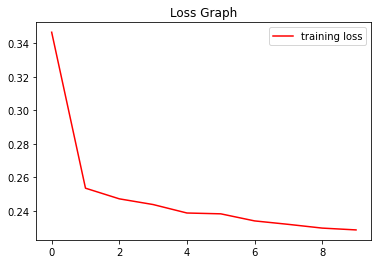

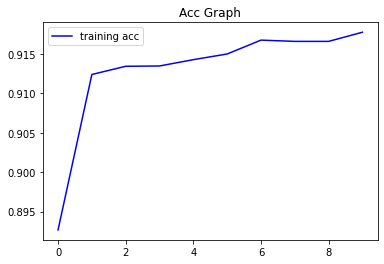

In [14]:
loss = history.history['loss']
acc = history.history['accuracy']

epoch = range(len(loss))

plt.plot(epoch,loss,'r',label='training loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()
plt.plot(epoch,acc,'b',label='training acc')
plt.title('Acc Graph')
plt.legend()
plt.show()


In [17]:
# storing the model parameters
model.save("mh_lstm_model.h5")

# input dictionary
dfile = open("mh_inp_dict.pkl",'wb')
pickle.dump(inp_dict, dfile)
dfile.close()

# output dictionary
dfile = open("mh_out_dict.pkl",'wb')
pickle.dump(out_dict, dfile)
dfile.close()


## Loading model and testing outputs

In [18]:
# loading all the model files
model = tf.keras.models.load_model("/content/mh_lstm_model.h5")

dfile = open("/content/mh_inp_dict.pkl", "rb")
inp_dict = pickle.load(dfile)

dfile = open("/content/mh_out_dict.pkl", "rb")
out_dict = pickle.load(dfile)


In [19]:
test_case_1 = {
        "Health": ["chronic pain, high blood pressure, physical disorder, heart disorder, physical disorder, eating disorder"],
        "Lifestyle": ["family, living alone, history of abuse, smoking, low sleep, drug abuse, mood swings, financial pressure"],
        "Work Style": ["low productivity, multitasking, pressure, overtime, negative work relations, high screen time, shift work, offshore, experience, less relax"]
}

test_case_2 = {
        "Health": ["anxiety, high blood pressure, hormonal imbalance, vitamin deficiency, thyroid, hormonal imbalance, thyroid, post traumatic stress"],
        "Lifestyle": ["alcohol, drug abuse, poor diet, stress, irregular sleep, confused, panic, high screen time, poor diet, hypnosis, day dream, fake emotions"],
        "Work Style": ["overtime, work stress, repeating tasks, improper recognition, work stress, work relations, overtime, negative work relations, repeating tasks"]
}

test_case_3 = {
        "Health": ["post traumatic stress, chronic pain, ocd, thyroid, diabetes, heart disorder"],
        "Lifestyle": ["history of abuse, low self esteem, high screen time, family, lack of relationships, negative social connection"],
        "Work Style": ["work stress, underperformer, introvert, incomplete tasks"]
}

test_case_4 = {
        "Health": [""],
        "Lifestyle": ["alcohol, drug abuse, poor diet"],
        "Work Style": ["work stress, underperformer, introvert"]
}


In [31]:
MAX_LEN = 50

# creating testing text
testdf = pd.DataFrame(test_case_2)

testdf = clean_text(testdf)

# encoding new text with inp dictionary
testinp = list()

for hm, lm, wm in zip(testdf['Health'],testdf['Lifestyle'],testdf['Work Style']):
  health = [w for w in hm.split(",")]
  health.pop(-1)

  lstyle = [w for w in lm.split(",")]
  lstyle.pop(-1)

  wstyle = [w for w in wm.split(",")]
  wstyle.pop(-1)

  testinp.append(health + lstyle + wstyle) 

# initializing the tokenizer with pre-built dictionary
test_token = Tokenizer()
test_token.word_index = inp_dict
xseq = test_token.texts_to_sequences(testinp)
xpadseq = pad_sequences(xseq,maxlen=MAX_LEN,padding='post')

# predicting the output
predicted = model.predict(xpadseq)
final_list = list()

for i in range(len(predicted)):
  res = list()
  pred = np.round( np.argmax(predicted[i],axis=1) )

  for w in pred:
    for word, index in out_dict.items():
      if index == w:
        res.append(word)
        break
    
  final_list.append(res)


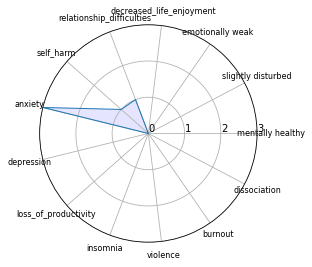

In [32]:
# the score dictionary
score_dict = dict()

N = len(mental_risks_list)

for risk in mental_risks_list:
  score_dict[risk] = 0

for risk in final_list[0]:
  for key in score_dict.keys():
    if key == risk:
      score_dict[key] += 1    

angles = [n / float(N) * 2 * pi for n in range(N)]

values = list(score_dict.values())
categories = list(score_dict.keys())

ax = plt.subplot(111, polar=True)
plt.xticks(angles, categories, color='black', size=8)

max_idx = max(score_dict, key=score_dict.get)
max_value = score_dict[max_idx]

ax.set_rlabel_position(0)
plt.yticks(list( range(0,(max_value + 1)) ), [str(n) for n in list( range(0,(max_value + 1)) )], color="black", size=10)
plt.ylim(0,max_value)

ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, 'b', alpha=0.1)

plt.show()
